# Scikit-learn Multi-layer Perceptron
**Created by**: Jordi Smit & Rembrandt Klazinga

This notebook uses the scikit-learn library for Python to train a neural network that is similar to the one you just built.
It is up to you to run the code blocks below and fill in the hyperparameters where necessary, these are exlained in more detail later.
Once all hyperparameters are sufficiently tweaked, you can compare the network's performance to that of your own.

This notebook requires the following libraries:

 - numpy
 - matplotlib
 - scikit-learn

The following code block will check if you have these libraries. If they are not installed this code block will automatically install them.

In [ ]:
import sys
!{sys.executable} -m pip install numpy matplotlib scikit-learn

### Imports
We start by importing all the modules we need. If this does not work make sure you have installed all the required modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.metrics import classification_report

random_seed = 42

### Preprocessing
Next, we read in the data and split it into a train, validation and test set. Feel free to change the `test_fraction` and `validation_fraction` such that they match the fractions you used to train your own Neural Network.

In [3]:
features = np.genfromtxt("features.txt", delimiter=",")
targets = np.genfromtxt("targets.txt", delimiter=",")
unknowns = np.genfromtxt("unknown.txt", delimiter=",")
labels = np.unique(targets)

test_fraction = 0.15 # Feel free to change
validation_fraction = 0.15 # Feel free to change
training_fraction = 1 - test_fraction - validation_fraction

assert 0.0 < test_fraction < 1.0, f"The test_fraction must be in the range (0.0, 1.0) but is {test_fraction}"
assert 0.0 < validation_fraction < 1.0, f"The validation_fraction must be in the range (0.0, 1.0) but is {validation_fraction}"
assert 0.0 < training_fraction < 1.0, f"The training_fraction must be in the range (0.0, 1.0) but is {training_fraction}"

x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=test_fraction, random_state=random_seed, stratify=targets)

### Finding the optimal hyperparameters
We are going to use grid search to find the optimal combination of hyperparameters. We have the following hyperparameters:

 - **hidden_layer_sizes**: A list of integers where by the ith element is the number of neurons in the ith hidden layer.
 - **activation**: Activation function for the hidden layer. You have the following options:
	 - 'identity' $f(x) = x$
	 - 'logistic' $f(x) = \frac{1}{ 1 + e^{-x}}$
	 - 'tanh'  $f(x) = tanh(x)$
	 - 'relu' $f(x) = max(0, x)$
 - **alpha**: L2 penalty (regularization term) parameter.
 - **solver**: The solver for weight optimization. You have the following options:
	 - 'sgd' The original version stochastic gradient descent.
	 - ‘adam’ A specialized version that automaticaly adapts it learning rates over time. Adam is significantly faster then SGD but uses more memory space.
 - **learning_rate_init**: The initial learning rate used. It controls the step-size in updating the weights.
 - **max_iter**: Maximum number of epochs (how many times each data point will be used, not the number of gradient steps). The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
 - **batch_size**:  The size of minibatches that will be given to stochastic optimizer. When set to 'auto', `batch_size=min(200,  n_samples)`
 - **validation_fraction**: The proportion of training data to set aside as validation set for early stopping. This hyperparameters is calculated automitcaly by our notebook, so you should not change this.
 - **early_stopping**: If set to true, it will terminate the training process when validation score is not improving by at least tol for `n_iter_no_change` consecutive epochs.
 - **n_iter_no_change**: Maximum number of epochs to not meet `tol` improvement.
 - **tol**: Tolerance for the optimization. When the loss or score is not improving by at least `tol` for `n_iter_no_change` consecutive iterations.

In the code below we have setup up grid search using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for Sklearn's [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). We have provided you with some default values for each of the hyperparameters. Feel free to try out additional values. You can probably improve the network by finding better values for `hidden_layer_sizes`, `activation`, `alpha` and `learning_rate_init`. You can do this by adding additional values to the list attributes of `grid`. The code below will provide you with the best values in the grid you have defined.


Be aware that the computational cost increases combinatorially with the number of options. Which means that you should be either very patient or you should choose wisely which values you want to try out. The grid search runs multiple training processes in parallel, making it a bit faster. By default this notebook will use all the processes it can get. However, this might be too much for some computers. If this is the case for you change `n_jobs` from `-1` to the number of processes you think is right (at least 1 of course).

In [4]:
n_jobs = -1

grid = [{
    # Network architecture
    'hidden_layer_sizes': [[5,5], [5, 5, 5]], # A list of integers
    'activation': ["logistic"], # "identity", "logistic", "tanh", "relu"
    'alpha': [0, 0.01], # Float
    
    # Optimizations parameters
    'solver': ["adam"], # "sgd", "adam"
    'learning_rate_init': [0.005, 0.01], # Float
    
    # Fitting parameters
    'max_iter': [200], # Integer
    'batch_size': ["auto"], # "auto" or an integer.
    
    # Validation
    'validation_fraction': [validation_fraction * len(features) * (1 - test_fraction) / len(features)], #Do not change this one.
    'early_stopping': [True], # Boolean, it is best to leave this on True.
    'n_iter_no_change': [10],# Integer
    'tol': [1e-4], # Float
    "random_state": [random_seed]
}]


grid_network = MLPClassifier(verbose=False, random_state=random_seed)


print(f"Grid search on grid:")
for k in grid[0]:
    print(f"-{k}: {grid[0][k]}")
print()

# Performing grid search to find best parameters
grid_search = GridSearchCV(grid_network, grid, n_jobs=n_jobs, verbose=True)
grid_search.fit(x_train, y_train)


print("Best parameters found by grid search:")
for k in grid_search.best_params_:
    print(f"-{k}: {grid_search.best_params_[k]}")
print()

Grid search on grid:
-hidden_layer_sizes: [[5, 5], [5, 5, 5]]
-activation: ['logistic']
-alpha: [0, 0.01]
-solver: ['adam']
-learning_rate_init: [0.005, 0.01]
-max_iter: [200]
-batch_size: ['auto']
-validation_fraction: [0.12749999999999997]
-early_stopping: [True]
-n_iter_no_change: [10]
-tol: [0.0001]
-random_state: [42]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.3s finished


Best parameters found by grid search:
-activation: logistic
-alpha: 0.01
-batch_size: auto
-early_stopping: True
-hidden_layer_sizes: [5, 5]
-learning_rate_init: 0.01
-max_iter: 200
-n_iter_no_change: 10
-random_state: 42
-solver: adam
-tol: 0.0001
-validation_fraction: 0.12749999999999997



### Analysing the best network
The grid search has provided us with the network with the best combination of hyperparameters (given our train, validation set and grid). In this section, we analyse this network in multiple aspects. Firstly, we compare the difference between the loss function (Sklearn uses [Multi Class Cross-Entropy](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#id11) loss), accuracy and MSE on the training and test set. These values should be relatively close else we are overfitting on the training data. Secondly, we look at the training loss and validation curve. These curves will give us some insight into how much epochs we need and if we need to stop earlier or not. Finally, we compare the confusion matrix of the training and test data set. This will give us some insight into which classes the network finds hard to predict and which classes generalize less well.

Resulting Training Cross-Entropy loss: 0.2770901419649013
Resulting Test Cross-Entropy loss: 0.2441390680989203

Resulting Training accuracy: 0.9144569288389514
Resulting Validation accuracy: 0.9084507042253521
Resulting Test accuracy: 0.9194232400339271

Resulting Training MSE: 0.018350451507519513
Resulting Test MSE: 0.01707735700637817


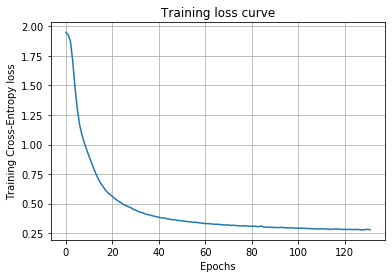

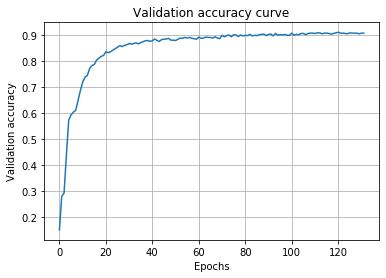

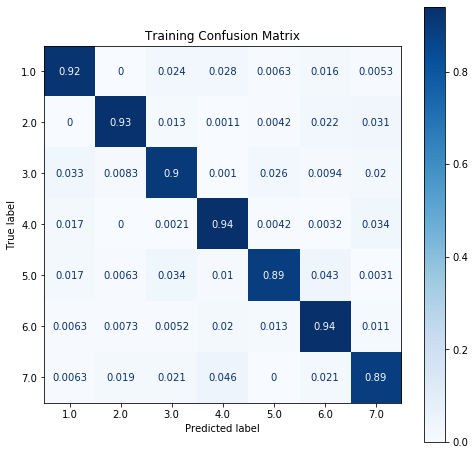

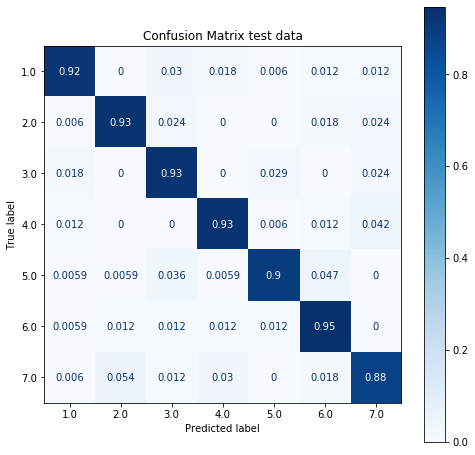

In [5]:
# Obtain the network based on grid search results
network = grid_search.best_estimator_

# Printing the Cross-Entropy losses
print(f"Resulting Training Cross-Entropy loss: {network.loss_curve_[-1]}")
print(f"Resulting Test Cross-Entropy loss: {log_loss(y_test, network.predict_proba(x_test), labels=labels)}")

print()

# Printing the accuracies
print(f"Resulting Training accuracy: {network.score(x_train, y_train)}")
print(f"Resulting Validation accuracy: {network.validation_scores_[-1]}")
print(f"Resulting Test accuracy: {network.score(x_test, y_test)}")

print()

# Printing the MSEs
mse_train = mean_squared_error(OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray(), network.predict_proba(x_train))
mse_test = mean_squared_error(OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray(), network.predict_proba(x_test))
print(f"Resulting Training MSE: {mse_train}")
print(f"Resulting Test MSE: {mse_test}")

# Plot Training loss curve
plt.plot(network.loss_curve_)
plt.grid()
plt.title("Training loss curve")
plt.xlabel("Epochs")
plt.ylabel("Training Cross-Entropy loss")
plt.show()

# Plot Validation accuracy curve
plt.plot(network.validation_scores_)
plt.grid()
plt.title("Validation accuracy curve")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.show()

# Plot training data Confusion Matrix
figure = plt.figure(figsize=(8,8))
ax = figure.add_subplot()
disp = plot_confusion_matrix(network, x_train, y_train,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize="true",
                                 ax=ax
                            )
disp.ax_.set_title("Training Confusion Matrix")
plt.show()

# Plot test data Confusion Matrix
figure = plt.figure(figsize=(8,8))
ax = figure.add_subplot()
disp = plot_confusion_matrix(network, x_test, y_test,
                                 display_labels=labels,
                                 cmap=plt.cm.Blues,
                                 normalize="true",
                                 ax=ax
                            )
disp.ax_.set_title("Confusion Matrix test data")
plt.show()

In [16]:
np.set_printoptions(suppress=True)
predictions = network.predict(unknowns).reshape(1, -1).astype(int)
np.savetxt('Group_00_classes.txt', predictions, delimiter=',')

In [17]:
predictions

array([[2, 6, 7, 1, 6, 5, 1, 3, 7, 7, 3, 3, 1, 3, 6, 4, 2, 4, 2, 2, 7, 5,
        6, 6, 5, 1, 1, 3, 1, 6, 6, 4, 4, 4, 4, 4, 5, 2, 2, 7, 4, 6, 5, 5,
        5, 7, 5, 4, 5, 1, 5, 5, 2, 1, 6, 3, 1, 4, 1, 1, 3, 6, 3, 2, 7, 2,
        2, 2, 7, 7, 7, 6, 7, 1, 4, 1, 4, 4, 1, 7, 1, 7, 6, 4, 4, 2, 1, 2,
        1, 7, 6, 2, 7, 1, 2, 7, 2, 2, 5, 2, 5, 7, 5, 5, 2, 6, 5, 6, 2, 3,
        7, 4, 1, 5, 5, 7, 6, 2, 4, 4, 7, 1, 2, 1, 1, 4, 7, 4, 7, 7, 7, 6,
        6, 7, 7, 4, 4, 4, 3, 5, 3, 4, 1, 3, 2, 6, 6, 5, 4, 4, 7, 4, 1, 7,
        1, 3, 7, 4, 3, 6, 7, 7, 3, 4, 1, 5, 6, 2, 5, 5, 3, 1, 6, 4, 7, 3,
        3, 5, 5, 1, 3, 4, 1, 1, 2, 3, 3, 2, 5, 3, 4, 6, 1, 6, 6, 2, 2, 3,
        6, 7, 7, 2, 5, 3, 5, 6, 7, 4, 2, 2, 5, 6, 2, 6, 6, 4, 2, 6, 1, 7,
        1, 3, 6, 2, 2, 6, 7, 1, 6, 1, 1, 5, 2, 4, 5, 4, 4, 4, 7, 7, 4, 1,
        5, 5, 3, 1, 1, 6, 6, 5, 4, 4, 6, 2, 6, 6, 6, 1, 5, 3, 5, 3, 3, 6,
        1, 2, 6, 6, 6, 2, 4, 5, 3, 5, 3, 3, 4, 7, 6, 4, 3, 6, 7, 7, 2, 7,
        7, 2, 1, 4, 6, 3, 4, 5, 4, 6, 